All contracts are defined as in the CDC24 paper.

== Missing spec
InVars: []
OutVars:[J1, J2]
A: [
  
]
G: [
  3 J1 - 1.6 J2 <= -0.6
  -2.8 J1 + 1.23 J2 <= -0.3
]
== Missing spec by hand
InVars: []
OutVars:[J1, J2]
A: [
  
]
G: [
  -2.8 J1 + 1.23 J2 <= -0.3
  3 J1 - 1.6 J2 <= -0.6
]


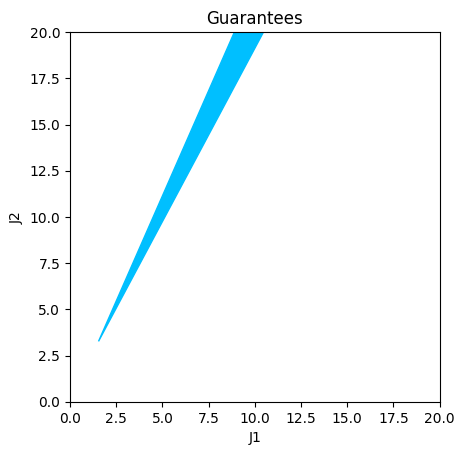

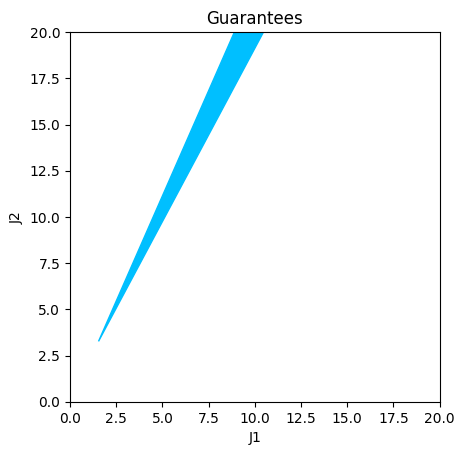

In [2]:
## constants
c = 1
delta = 1
# sigma 1
F_1_u_s = 5
F_1_u_h = 4
# sigma 2
p2_h = 0.6
p1_s = 1.1
p1_h = 0.3
F_2_p_1_s = 4.1
F_2_p_1_h = 4

# The following don't affect results
u_h = 10
u_s = 100


from pacti.contracts import PolyhedralIoContract
from pacti.terms.polyhedra import PolyhedralTermList, PolyhedralTerm
from pacti.utils import plots
from pacti.iocontract import Var
import numpy as np


top_level_objective = PolyhedralIoContract.from_strings(
    input_vars=["u"],
    output_vars=["p2"],
    assumptions=[f"{u_h}<= u <= {u_s}"],
    guarantees=[
    f"p2 >= {p2_h}"
    ]
    )


sigma1 = PolyhedralIoContract.from_strings(
    input_vars=["d1", "d2"],
    output_vars=["p1"],
    assumptions=[
    f"{(delta/c)*p1_h}*(1 + d1 + d2) <= d1",
    f"{(delta/c)*p1_s}*(1 + d1 + d2) >= d1",
    ],
    guarantees=[f"{p1_h} <= p1 <= {p1_s}"]
    )

sigma2 = PolyhedralIoContract.from_strings(
    input_vars=["d1", "d2", "p1"],
    output_vars=["p2"],
    assumptions=[
    f"{p1_h} <= p1 <= {p1_s}",
    f"{(delta/c)*p2_h}*(1 + d1 + d2) <= d2",
    ],
    guarantees=[f"{p2_h} <= p2"]
    )

resource_sharing = PolyhedralIoContract.from_strings(
    input_vars=["J1","J2","u"],
    output_vars=["d1","d2"],
    assumptions=[f"{u_h}<= u <= {u_s}"],
    guarantees=[
    f"{F_1_u_h} J1 <= d1 <= {F_1_u_s} J1",
    f"{F_2_p_1_h} J2 <= d2 <= {F_2_p_1_s} J2"
    ],
    )

by_hand = PolyhedralIoContract.from_strings(
    input_vars=[],
    output_vars=["J1","J2"],
    assumptions=[],
    guarantees=[
    f"{-F_1_u_h*(p1_s - 1)}*J1 - {p1_s*(F_2_p_1_h)} * J2 <= {p1_s}",
    f"{-F_1_u_h*(1 - p1_h)}*J1 + {p1_h*(F_2_p_1_s)} * J2 <= {-p1_h}",
    f"{F_1_u_s*(p2_h)}*J1 - {(1-p2_h)*(F_2_p_1_h)} * J2 <= {-p2_h}",
    ],
    )


system_spec = sigma1.compose(sigma2).compose(resource_sharing)

system_h_threshold = top_level_objective.quotient(system_spec)
print(f"== Missing spec\n{system_h_threshold}")
print(f"== Missing spec by hand\n{by_hand}")

_ = plots.plot_guarantees(contract=system_h_threshold,x_var=Var("J1"),y_var=Var("J2"),x_lims=(0,20),y_lims=(0,20),var_values={})
_ = plots.plot_guarantees(contract=system_h_threshold,x_var=Var("J1"),y_var=Var("J2"),x_lims=(0,20),y_lims=(0,20),var_values={})

[ 10.   32.5  55.   77.5 100. ]
u is 10.0. f1u is 4.0/4/5. f2p1 is 4.003460370807963/4/4.1
u is 32.5. f1u is 4.25/4/5. f2p1 is 4.005135509228737/4/4.1
u is 55.0. f1u is 4.5/4/5. f2p1 is 4.006744346581478/4/4.1
u is 77.5. f1u is 4.75/4/5. f2p1 is 4.008290788916566/4/4.1
u is 100.0. f1u is 5.0/4/5. f2p1 is 4.009778437988776/4/4.1


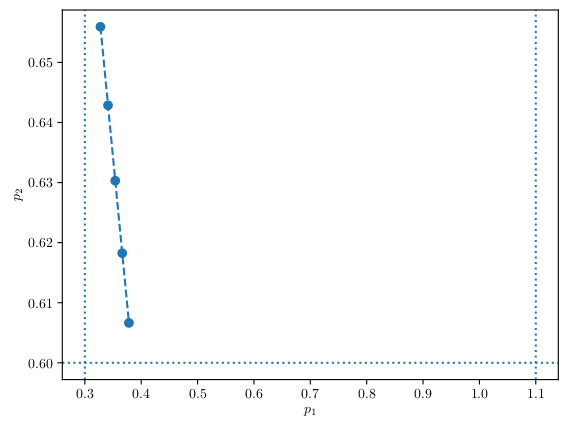

In [16]:
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
plt.close('all')
#%matplotlib inline


def f1(x):
    return (F_1_u_s - F_1_u_h)/(u_s - u_h) * (x - u_h) + F_1_u_h

def f2(x):
    return (F_2_p_1_s - F_2_p_1_h)/(p1_s - p1_h) * (x - p1_h) + F_2_p_1_h

def F1(p1,theta1,theta2,u):
    return p1*(1 + theta1*f1(u) + theta2*f2(p1)) - theta1*f1(u)

def F2(theta1,theta2,u,p1):
    print(f"u is {u}. f1u is {f1(u)}/{F_1_u_h}/{F_1_u_s}. f2p1 is {f2(p1)}/{F_2_p_1_h}/{F_2_p_1_s}")
    return theta2*f2(p1) / (1 + theta1*f1(u) + theta2*f2(p1))

def getsol(theta1,theta2,u):
    a=fsolve(F1,1,args=(theta1,theta2,u))
    b=F2(theta1,theta2,u,a[0])
    return a[0],b
    
# setup a figure with requirements
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$p_1$")
ax.set_ylabel("$p_2$")
ax.axhline(y=p2_h,linestyle=":")
ax.axvline(x=p1_h,linestyle=":")
ax.axvline(x=p1_s,linestyle=":")

# given a value of parameters, return values to plot
def getplot(theta1,theta2):
    u_vals = np.linspace(u_h,u_s,5)
    print(u_vals)
    data = [getsol(theta1,theta2,val) for val in u_vals]
    return list(map(list,zip(*data)))    


def getsatassignment(contract : PolyhedralIoContract):
    h = 3.1
    l = 1.6
    d = h - l
    p1val = np.random.random_sample() * d + l
    g : PolyhedralIoContract = contract.g.copy()
    term : PolyhedralTerm
    for term in g:
        term.substitute_variable(Var('p1'),PolyhedralTerm())
    return 5,10

#theta1 = 5
#theta2 = 10

theta1, theta2 = getsatassignment(system_h_threshold)

xx,yy = getplot(theta1,theta2)


ax.plot(xx,yy,"--o")


fig

Now we analyze constraints to guarantee the low thresholds

== Missing spec
InVars: []
OutVars:[J1, J2]
A: [
  
]
G: [
  0.06 J2 <= 0.4
  0.014 J1 <= 0.3
]


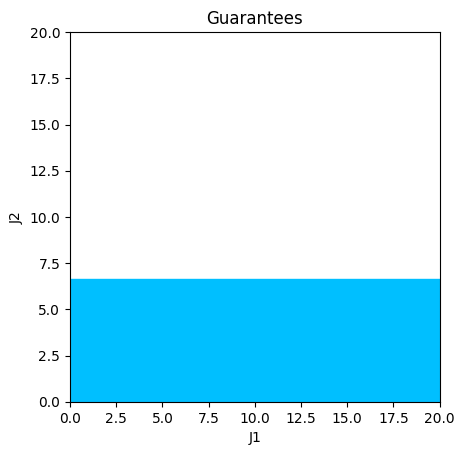

In [4]:
# sigma 1
F_1_u_m = 0
F_1_u_l = 0.02
# sigma 2
p2_l = 0.4
p1_l = 0.3
F_2_p_1_m = 0
F_2_p_1_l = 0.1

# The following don't affect results
u_l = 1
u_m = 0


top_level_objective_l = PolyhedralIoContract.from_strings(
    input_vars=["u"],
    output_vars=["p2"],
    assumptions=[f"{u_m}<= u <= {u_l}"],
    guarantees=[
    f"p2 <= {p2_l}"
    ]
    )


sigma1 = PolyhedralIoContract.from_strings(
    input_vars=["d1", "d2"],
    output_vars=["p1"],
    assumptions=[
    f"{(delta/c)*p1_l}*(1 + d1 + d2) >= d1",
    ],
    guarantees=[f"p1 <= {p1_l}"]
    )

sigma2 = PolyhedralIoContract.from_strings(
    input_vars=["d1", "d2", "p1"],
    output_vars=["p2"],
    assumptions=[
    f"p1 <= {p1_l}",
    f"{(delta/c)*p2_l}*(1 + d1 + d2) >= d2",
    ],
    guarantees=[f"{p2_l} >= p2"]
    )

resource_sharing = PolyhedralIoContract.from_strings(
    input_vars=["J1","J2","u"],
    output_vars=["d1","d2"],
    assumptions=[f"{u_m}<= u <= {u_l}"],
    guarantees=[
    f"{F_1_u_m} J1 <= d1 <= {F_1_u_l} J1",
    f"{F_2_p_1_m} J2 <= d2 <= {F_2_p_1_l} J2"
    ],
    )

system_spec_l = sigma1.compose(sigma2).compose(resource_sharing)
system_l_threshold = top_level_objective_l.quotient(system_spec_l)
print(f"== Missing spec\n{system_l_threshold}")

_ = plots.plot_guarantees(contract=system_l_threshold,x_var=Var("J1"),y_var=Var("J2"),x_lims=(0,20),y_lims=(0,20),var_values={})


The following plot shows the feasible region of the $J_i$ that will allow the circuit to meet its lower and upper thresholds.

== Overall spec
InVars: []
OutVars:[J1, J2]
A: [
  
]
G: [
  0.06 J2 <= 0.4
  3 J1 - 1.6 J2 <= -0.6
  -2.8 J1 + 1.23 J2 <= -0.3
]


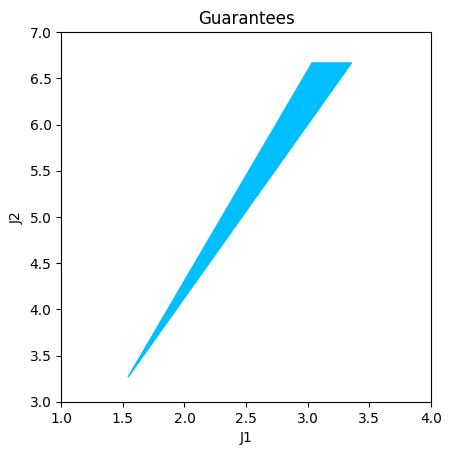

In [5]:
# We merge the upper and lower requirements to obtain J parameters that would ensure that the system meets both thresholds
overall_system = system_l_threshold.merge(system_h_threshold)
print(f"== Overall spec\n{overall_system}")
_ = plots.plot_guarantees(contract=overall_system,x_var=Var("J1"),y_var=Var("J2"),x_lims=(1,4),y_lims=(3,7),var_values={})

In [6]:
import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

_.set_size_inches(w=2, h=3)
_.savefig('sequential.pgf',bbox_inches='tight')